In [201]:
import geomstats
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.stiefel import Stiefel
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
from shape_vis.py import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

ModuleNotFoundError: No module named 'shape_vis.py'; 'shape_vis' is not a package

### TODO: introduction

### Loading data

In [159]:
data, ids, target=load_connectomes()
print(data.shape)
print(target)

(86, 28, 28)
[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1]


### Manifold of connectomes

In [5]:
# show that connectomes belong to manifold of spd matrices
spd = SPDMatrices(28)
spd_affine = SPDBuresWassersteinMetric(28)
stiefel = Stiefel(28,1)
print(spd.belongs(data),'\n',stiefel.belongs(data))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True] 
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False Fals

### Processing samples

In [9]:
adj_schiz, adj_norm = np.ceil(data[:2])
g_schiz = nx.from_numpy_array(adj_schiz)
g_norm = nx.from_numpy_array(adj_norm)

In [107]:
# Common metrics used for SPD
### Will figure out how to implement
ai_metric = SPDAffineMetric(28)
le_metric = SPDLogEuclideanMetric(28)

In [153]:
# Example computation for squared dist metric
one_schiz, one_healthy  = data[:2]
schiz_label, healthy_label = target[:2]
print(healthy_label)
print(schiz_label)
spd_affine.squared_dist(one_schiz, one_healthy)

0
1


3.7374906977161757

In [155]:
proj_schiz,proj_norm=spd.projection(adj_schiz),spd.projection(adj_norm)
np.mean(spd_affine.log(proj_schiz,proj_norm))
# ?

nan

In [145]:
bool_list = list(map(bool,target))
schiz = data[bool_list]
print(schiz.shape)
ave_schiz = np.sum(schiz, axis = 0)/len(schiz[0])
schiz_spd = spd.projection(schiz)

(40, 28, 28)


In [146]:
flip_bool_list = [not elem for elem in bool_list]
healthy = data[flip_bool_list]
print(healthy.shape)
ave_schiz = np.sum(healthy, axis = 0)/len(healthy[0])
healthy_spd = spd.projection(healthy)

(46, 28, 28)


In [147]:
sqrd_dist = []
for i in range(len(healthy_spd[:])):
    for j in range(len(schiz_spd[:])):
        sqrd_dist.append(spd_affine.squared_dist(healthy_spd[i], schiz_spd[j]))

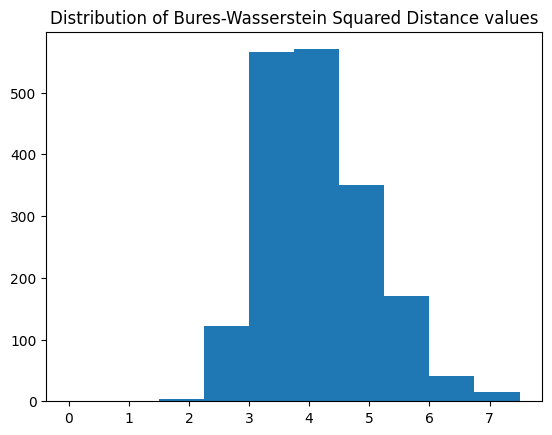

In [190]:
plt.hist(sqrd_dist,range=(0,np.max(sqrd_dist)))
plt.title('Distribution of Bures-Wasserstein Squared Distance values')
plt.show()

In [188]:
log_vec = np.zeros((40*46, 28, 28))
k = 0
for i in range(len(healthy_spd[:])):
    for j in range(len(schiz_spd[:])):
        log_vec[k] = (spd_affine.log(healthy_spd[i], schiz_spd[j]))
        k += 1

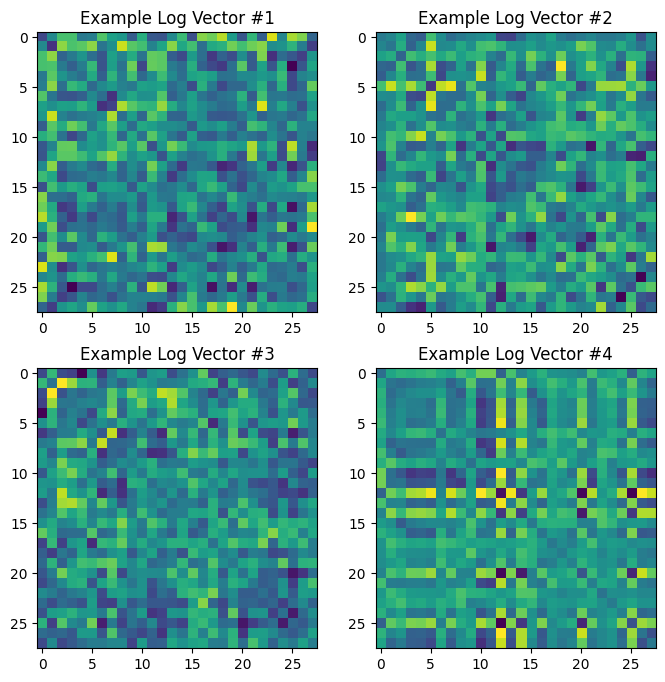

In [189]:
random_vecs = np.random.randint(log_vec.shape[0], size=4)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(221)
imgplot = ax.imshow(log_vec[random_vecs[0]])
ax.set_title('Example Log Vector #1')

ax = fig.add_subplot(222)
imgplot = ax.imshow(log_vec[random_vecs[1]])
ax.set_title('Example Log Vector #2')

ax = fig.add_subplot(223)
imgplot = ax.imshow(log_vec[random_vecs[2]])
ax.set_title('Example Log Vector #3')

ax = fig.add_subplot(224)
imgplot = ax.imshow(log_vec[random_vecs[3]])
ax.set_title('Example Log Vector #4')

plt.show()

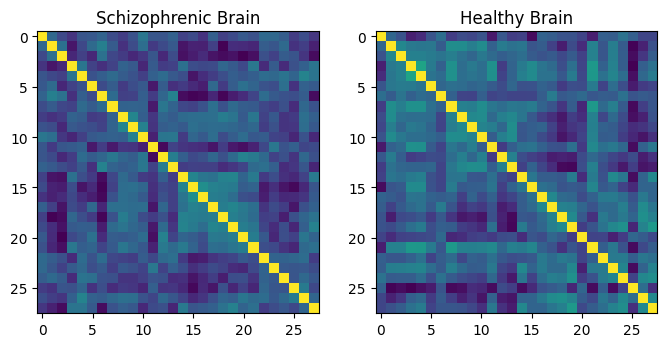

In [98]:
labels_str = ["Healthy Brain", "Schizophrenic Brain"]

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(121)
imgplot = ax.imshow(data[0])
ax.set_title(labels_str[target[0]])

ax = fig.add_subplot(122)
imgplot = ax.imshow(data[1])
ax.set_title(labels_str[target[1]])

plt.show()

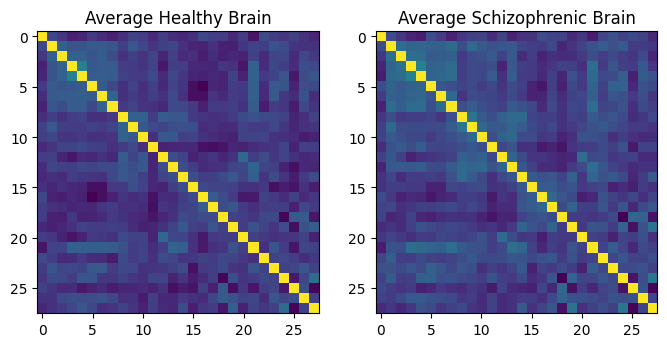

In [106]:
labels_str = ["Average Healthy Brain", "Average Schizophrenic Brain"]

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(121)
imgplot = ax.imshow(ave_healthy)
ax.set_title(labels_str[0])

ax = fig.add_subplot(122)
imgplot = ax.imshow(ave_schiz)
ax.set_title(labels_str[1])

plt.show()

### Spatial comparison

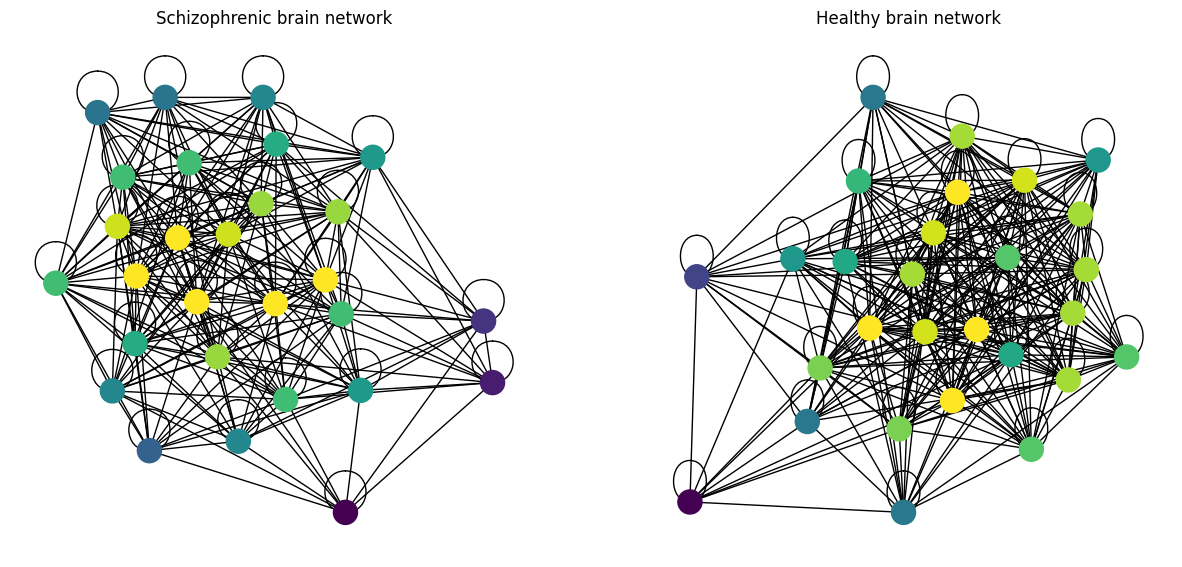

In [93]:
def plot_graphs_spatial(nx_graph,subgraph_id,title):
    plt.subplot(subgraph_id)
    degrees = [n for n in nx.degree_centrality(nx_graph).values()]
    nx.draw(nx_graph,pos=None,with_labels=False,node_color=degrees)
    plt.title(title)

plt.figure(figsize=(15,15))
plot_graphs_spatial(g_schiz,221,"Schizophrenic brain network")
plot_graphs_spatial(g_norm,222,"Healthy brain network")
plt.show()

### Spectral comparison

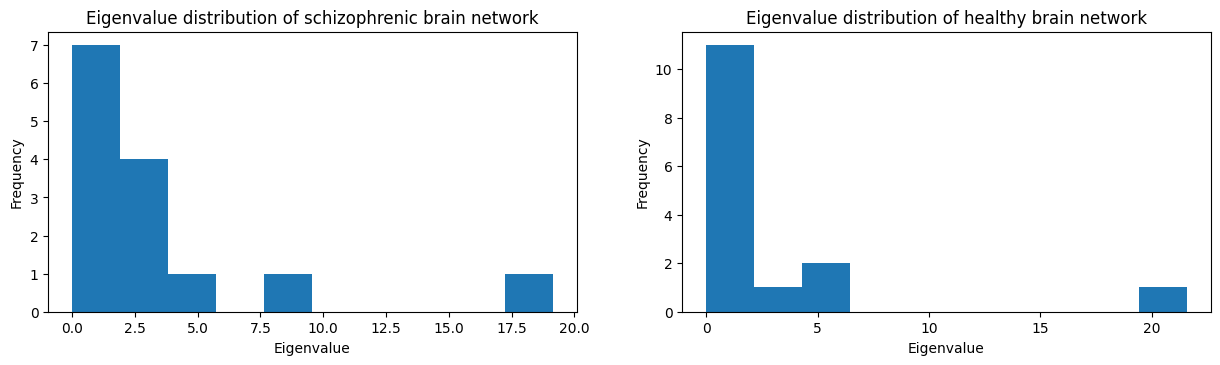

In [94]:
def plot_graphs_spectral(nx_graph,subgraph_id,title):
    evals,_ = npla.eig(nx.adjacency_matrix(nx_graph).todense())
    plt.subplot(subgraph_id)
    plt.hist(evals,range=(0,np.max(evals)))
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title(title)

plt.figure(figsize=(15,8))
plot_graphs_spectral(g_schiz,221,"Eigenvalue distribution of schizophrenic brain network")
plot_graphs_spectral(g_norm,222,"Eigenvalue distribution of healthy brain network")
plt.show()

NOTE: The eigenvalues of the schizophrenic brain network are skewed to higher values. This aligns with the finding in [] that anomalous networks are associated with higher spectral energy.